# Copyright Netherlands eScience Center <br>
**Function     : Preliminary check of addressing uncertainty with BayesianLSTM** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.11.08** <br>
**Last Update  : 2020.11.08** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to make figures for the paper.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# sensitivity test parameter
sense = 'x'
#sense = 'a'
# model type
model_type = 'lorenz84ex' # choose lorenz84 / lorenz84ex / lorenz84AA
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex'
# data path of experiment
if sense == 'x':
    data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_0001_ex\\lorenz'
elif sense == 'a':
    data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\a_00001_ex\\lorenz'
else:
    raise IOError("The chosen variable is not supported for sensitivity experiment!")

#pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100'
#pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\longLeadTime'
#pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\layer3'
path_e1500_p1000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch1500_p1000_stdx4'
path_e3000_p100_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100_stdx4'
path_e3000_p1000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p1000_stdx4'
path_e3000_p10000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p10000_stdx4'
path_e3000_p100000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx4'
path_e3000_p100000_stdx16 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx16'
path_e3000_p1000000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p1000000_stdx4'
path_e3000_p10000000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p10000000_stdx4'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>

In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

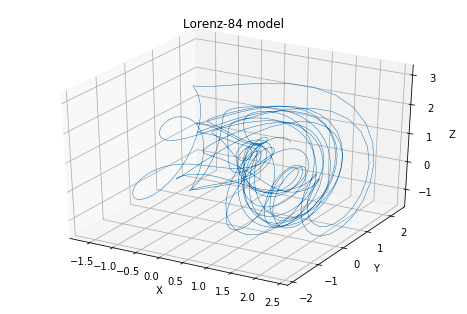

<Figure size 432x288 with 0 Axes>

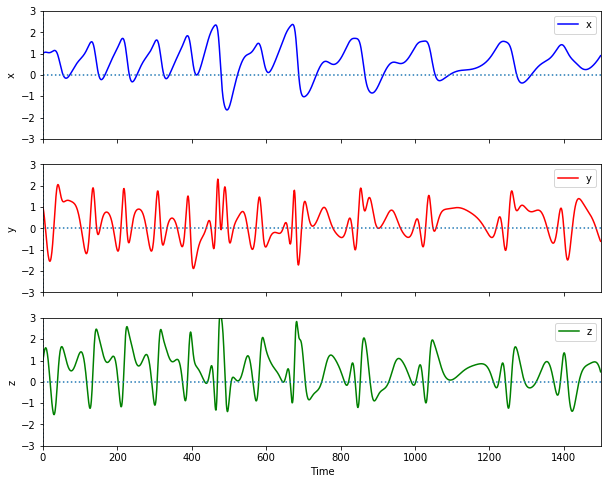

In [9]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

===================  load data  =====================
===================  visualize data  =====================
===================  whole time series  =====================


<Figure size 432x288 with 0 Axes>

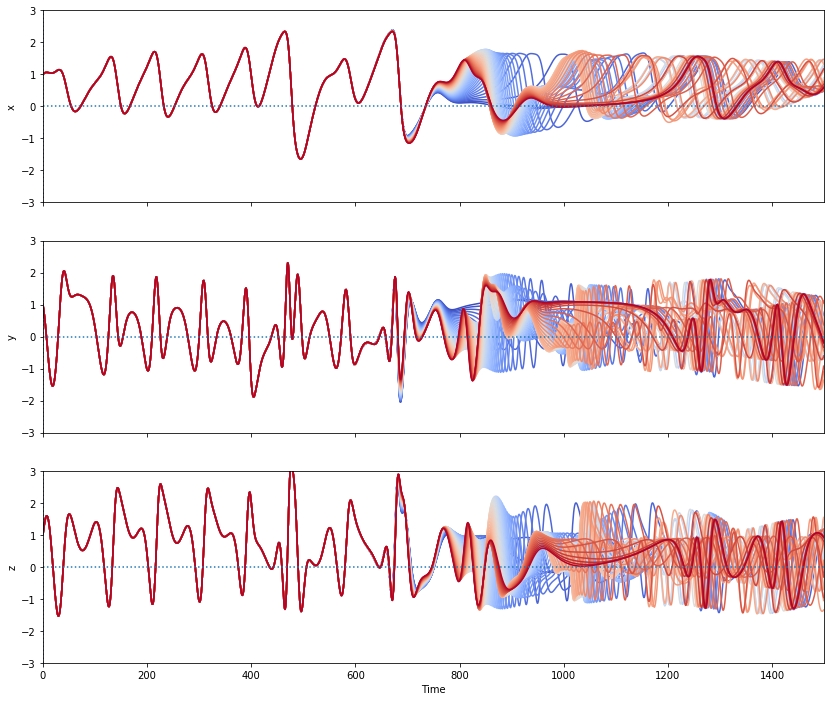

===================  testing period time series  =====================


<Figure size 432x288 with 0 Axes>

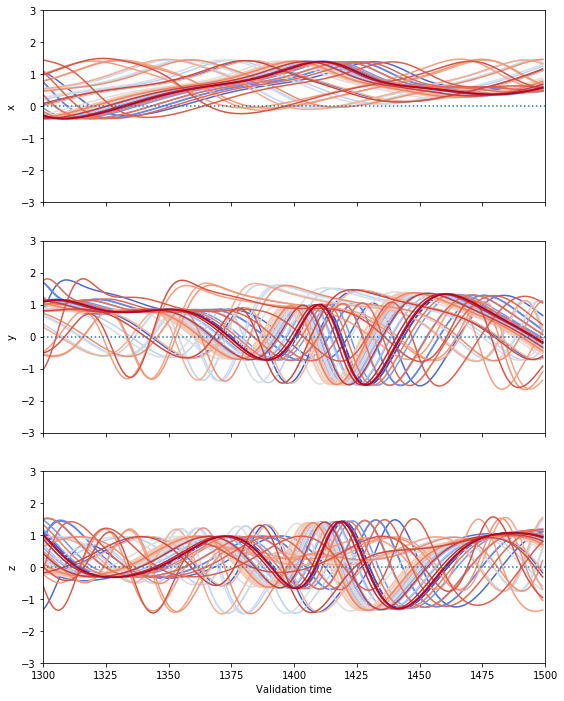

In [11]:
    #################################################################################
    ###########        Precheck Lorenz 84 model ensemble output           ###########
    #################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(num_steps)
    # number of ensembles
    ens = 51
    data_ens = np.zeros((ens, 3, num_steps), dtype=float)
    # load data
    for i in range(ens):
        if sense == 'x':
            dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        #extract data
        data_ens[i,:,:] = dataset.variables['series'][:]
    
    print ('===================  visualize data  =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.hsv(range(ens))
    colormap=cm.prism(range(ens))
    #colormap=cm.gist_ncar(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    colormap = plt.get_cmap('coolwarm', ens)
    #colormap = plt.get_cmap('jet', 51)
    
    print ('===================  whole time series  =====================')
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(14, 12, forward=True)
    for i in range(ens):
        ax1.plot(index, data_ens[i, 0, :], color=colormap(i), label='x-ens-{}'.format(i))
        ax2.plot(index, data_ens[i, 1, :], color=colormap(i), label='y-ens-{}'.format(i))
        ax3.plot(index, data_ens[i, 2, :], color=colormap(i), label='z-ens-{}'.format(i))
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')

    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    #ax2.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    #ax3.legend(frameon=True, loc=3, prop={'size': 11}, ncol=6)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")

    plt.show()

    print ('===================  testing period time series  =====================')
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    for i in range(ens):
        ax1.plot(index[-test_len:], data_ens[i, 0, -test_len:], color=colormap(i), label='x-ens-{}'.format(i))
        ax2.plot(index[-test_len:], data_ens[i, 1, -test_len:], color=colormap(i), label='y-ens-{}'.format(i))
        ax3.plot(index[-test_len:], data_ens[i, 2, -test_len:], color=colormap(i), label='z-ens-{}'.format(i))
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(num_steps-test_len, num_steps)
    ax2.set_xlim(num_steps-test_len, num_steps)
    ax3.set_xlim(num_steps-test_len, num_steps)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8}, ncol=6)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Validation time")    

    plt.show()  

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [12]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std
    x_std = np.std(x)
    y_std = np.std(y)
    z_std = np.std(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


# Postprocess forecast data <br>
** Postprocess and visualization of ensemble forecast data ** <br>

In [16]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 16 # unit week
    # number of ensembles
    ens = 20
    predictand_e1500_p1000_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p100_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p1000_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p10000_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p100000_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p100000_stdx16 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p1000000_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_e3000_p10000000_stdx4 = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred_e1500_p1000_stdx4 = Dataset(os.path.join(path_e1500_p1000_stdx4,
                                                 'pred_lorenz84_epoch1500_p1000_stdx4_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p100_stdx4 = Dataset(os.path.join(path_e3000_p100_stdx4,
                                                'pred_lorenz84_epoch3000_p100_stdx4_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p1000_stdx4 = Dataset(os.path.join(path_e3000_p1000_stdx4,
                                                 'pred_lorenz84_epoch3000_p1000_stdx4_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p10000_stdx4 = Dataset(os.path.join(path_e3000_p10000_stdx4,
                                                  'pred_lorenz84_epoch3000_p10000_stdx4_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p100000_stdx4 = Dataset(os.path.join(path_e3000_p100000_stdx4,
                                                   'pred_lorenz84_epoch3000_p100000_stdx4_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p100000_stdx16 = Dataset(os.path.join(path_e3000_p100000_stdx16,
                                                    'pred_lorenz84_epoch3000_p100000_stdx16_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p1000000_stdx4 = Dataset(os.path.join(path_e3000_p1000000_stdx4,
                                                    'pred_lorenz84_epoch3000_p1000000_stdx4_ens_{}.nc'.format(i)))
        dataset_pred_e3000_p10000000_stdx4 = Dataset(os.path.join(path_e3000_p10000000_stdx4,
                                                    'pred_lorenz84_epoch3000_p10000000_stdx4_ens_{}.nc'.format(i)))
        predictand_e1500_p1000_stdx4[i,:,:,:] = dataset_pred_e1500_p1000_stdx4.variables['series'][:,:,:step_lead]
        predictand_e3000_p100_stdx4[i,:,:,:] = dataset_pred_e3000_p100_stdx4.variables['series'][:,:,:step_lead]
        predictand_e3000_p1000_stdx4[i,:,:,:] = dataset_pred_e3000_p1000_stdx4.variables['series'][:,:,:step_lead]
        predictand_e3000_p10000_stdx4[i,:,:,:] = dataset_pred_e3000_p10000_stdx4.variables['series'][:,:,:step_lead]
        predictand_e3000_p100000_stdx4[i,:,:,:] = dataset_pred_e3000_p100000_stdx4.variables['series'][:,:,:step_lead]
        predictand_e3000_p100000_stdx16[i,:,:,:] = dataset_pred_e3000_p100000_stdx16.variables['series'][:,:,:step_lead]
        predictand_e3000_p1000000_stdx4[i,:,:,:] = dataset_pred_e3000_p1000000_stdx4.variables['series'][:,:,:step_lead]
        predictand_e3000_p10000000_stdx4[i,:,:,:] = dataset_pred_e3000_p10000000_stdx4.variables['series'][:,:,:step_lead]
    print(predictand_e1500_p1000_stdx4.shape)
    print(predictand_e3000_p100_stdx4.shape)
    print(predictand_e3000_p1000_stdx4.shape)
    print(predictand_e3000_p10000_stdx4.shape)
    print(predictand_e3000_p100000_stdx4.shape)
    
    predictand_median_e1500_p1000_stdx4 = np.median(predictand_e1500_p1000_stdx4, 0)
    predictand_median_e3000_p100_stdx4 = np.median(predictand_e3000_p100_stdx4, 0)
    predictand_median_e3000_p1000_stdx4 = np.median(predictand_e3000_p1000_stdx4, 0)
    predictand_median_e3000_p10000_stdx4 = np.median(predictand_e3000_p10000_stdx4, 0)
    predictand_median_e3000_p100000_stdx4 = np.median(predictand_e3000_p100000_stdx4, 0)
    predictand_median_e3000_p100000_stdx16 = np.median(predictand_e3000_p100000_stdx16, 0)
    predictand_median_e3000_p1000000_stdx4 = np.median(predictand_e3000_p1000000_stdx4, 0)
    predictand_median_e3000_p10000000_stdx4 = np.median(predictand_e3000_p10000000_stdx4, 0)

*******************  load ensemble data  *********************
(20, 3, 200, 16)
(20, 3, 200, 16)
(20, 3, 200, 16)
(20, 3, 200, 16)
(20, 3, 200, 16)


In [17]:
    #######################################################################
    ########         Load perturbed Lorenz 84 model output         ########
    #######################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(test_len)
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, test_len), dtype=float)
    # load data
    for i in range(ens_obs):
        if sense == 'x':
            dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        else:
            raise IOError("The chosen variable is not supported for sensitivity experiment!")    
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]

===================  load data  =====================


<Figure size 432x288 with 0 Axes>

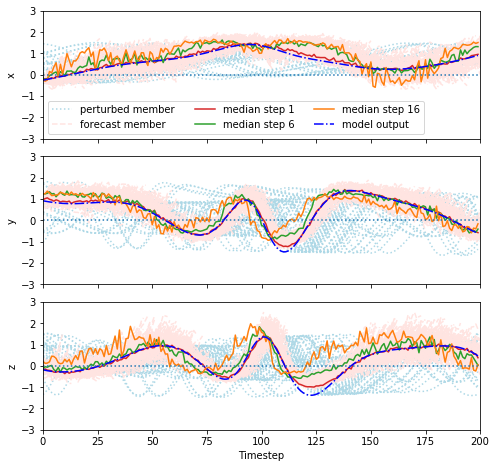

In [13]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p100_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p100_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p100_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p100_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p100_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p100_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p100_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p100_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p100_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    #ax1.plot(index, np.median(data_ens[:, 0, :], 0), color='blue', linestyle='dashdot', label='x obs')
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, np.median(data_ens[:, 1, :], 0), color='blue', linestyle='dashdot', label='y obs').
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, np.median(data_ens[:, 2, :], 0), color='blue', linestyle='dashdot', label='z obs')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p100_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p100_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

<Figure size 432x288 with 0 Axes>

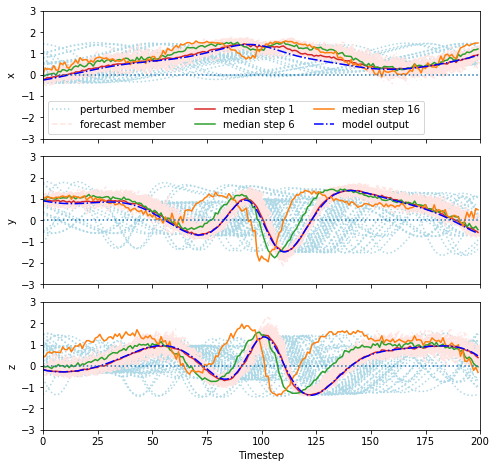

In [14]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e1500_p1000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e1500_p1000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e1500_p1000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e1500_p1000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e1500_p1000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e1500_p1000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e1500_p1000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e1500_p1000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e1500_p1000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e1500_p1000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e1500_p1000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e1500_p1000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e1500_p1000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e1500_p1000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e1500_p1000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e1500_p1000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e1500_p1000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

<Figure size 432x288 with 0 Axes>

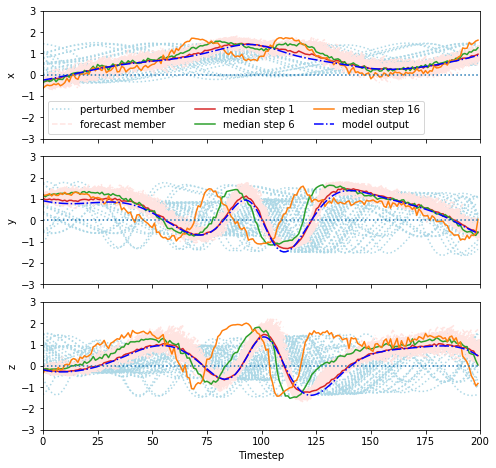

In [15]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p1000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p1000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p1000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p1000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p1000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p1000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p1000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p1000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p1000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')

    #ax1.plot(index, data_ens[25, 0, :], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, data_ens[25, 1, :], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, data_ens[25, 2, :], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p1000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p1000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

<Figure size 432x288 with 0 Axes>

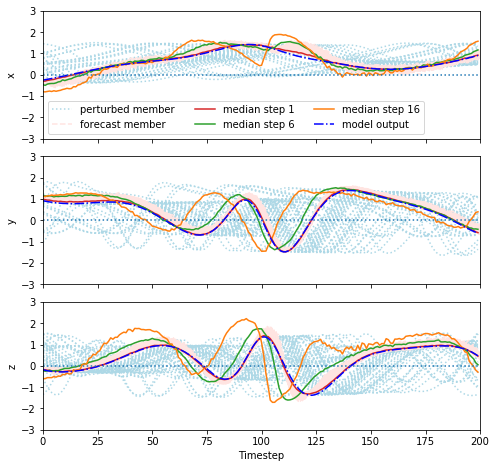

In [12]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p10000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p10000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p10000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p10000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p10000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p10000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p10000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p10000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p10000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')

    #ax1.plot(index, data_ens[25, 0, :], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, data_ens[25, 1, :], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, data_ens[25, 2, :], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p10000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p10000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

<Figure size 432x288 with 0 Axes>

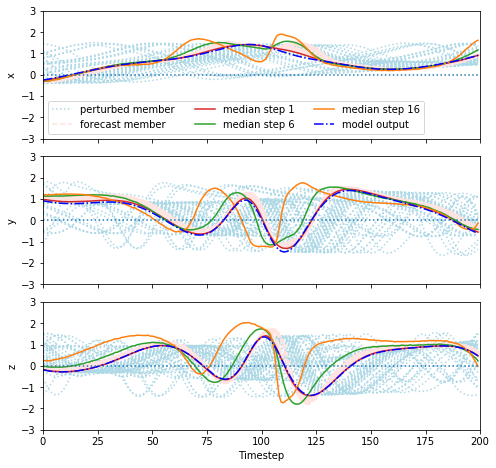

In [12]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p100000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p100000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p100000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p100000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p100000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p100000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p100000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p100000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p100000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')

    #ax1.plot(index, data_ens[25, 0, :], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, data_ens[25, 1, :], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, data_ens[25, 2, :], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p100000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p100000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

<Figure size 432x288 with 0 Axes>

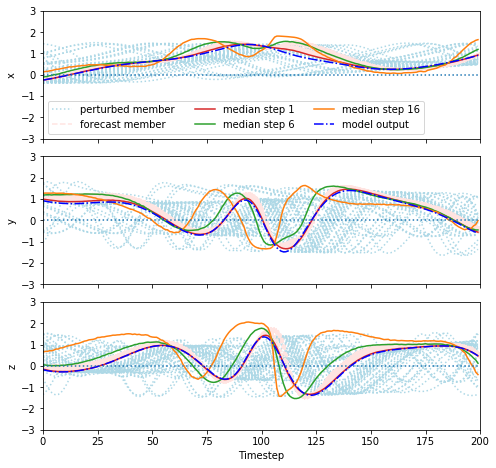

In [18]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx16[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx16[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx16[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx16[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx16[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p100000_stdx16[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p100000_stdx16[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p100000_stdx16[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p100000_stdx16[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p100000_stdx16[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p100000_stdx16[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p100000_stdx16[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p100000_stdx16[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p100000_stdx16[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p100000_stdx16[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')

    #ax1.plot(index, data_ens[25, 0, :], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, data_ens[25, 1, :], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, data_ens[25, 2, :], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p100000_stdx16.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p100000_stdx16.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

In [ ]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p1000000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p1000000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p1000000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p1000000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p1000000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p1000000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p1000000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p1000000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p1000000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p1000000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')

    #ax1.plot(index, data_ens[25, 0, :], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, data_ens[25, 1, :], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, data_ens[25, 2, :], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p1000000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p1000000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

In [ ]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(7, 6.6, forward=True)

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted', label='perturbed member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted', label='perturbed member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')  
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed', label='forecast member')
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000000_stdx4[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color='mistyrose', linestyle='dashed')
                ax2.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000000_stdx4[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color='mistyrose', linestyle='dashed')
                ax3.plot(index_lead[j:j+step_lead_display], predictand_e3000_p10000000_stdx4[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color='mistyrose', linestyle='dashed')

    # median
    # step 1
    ax1.plot(index, predictand_median_e3000_p10000000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax2.plot(index, predictand_median_e3000_p10000000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1')
    ax3.plot(index, predictand_median_e3000_p10000000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1')
    
    # step 6
    ax1.plot(index, predictand_median_e3000_p10000000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax2.plot(index, predictand_median_e3000_p10000000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6')
    ax3.plot(index, predictand_median_e3000_p10000000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6')
    
    # step 16
    ax1.plot(index, predictand_median_e3000_p10000000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax2.plot(index, predictand_median_e3000_p10000000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    ax3.plot(index, predictand_median_e3000_p10000000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16')
    
    # ground truth
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='model output')

    #ax1.plot(index, data_ens[25, 0, :], color='blue', linestyle='dashdot', label='model output')
    #ax2.plot(index, data_ens[25, 1, :], color='blue', linestyle='dashdot', label='model output')
    #ax3.plot(index, data_ens[25, 2, :], color='blue', linestyle='dashdot', label='model output')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=3)
    #ax2.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)
    #ax3.legend(frameon=True, loc=3, prop={'size': 8.5}, ncol=3)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'perturbation_initialC_forecast_series_e3000_p10000000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'perturbation_modelP_forecast_series_e3000_p10000000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


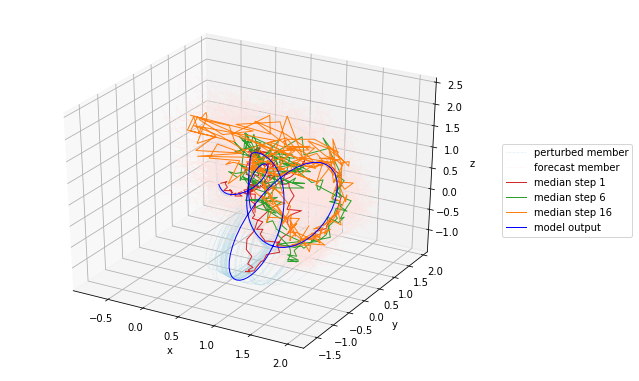

In [16]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p100_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p100_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p100_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p100_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p100_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p100_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p100_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p100_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p100_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0)    
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p100_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p100_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


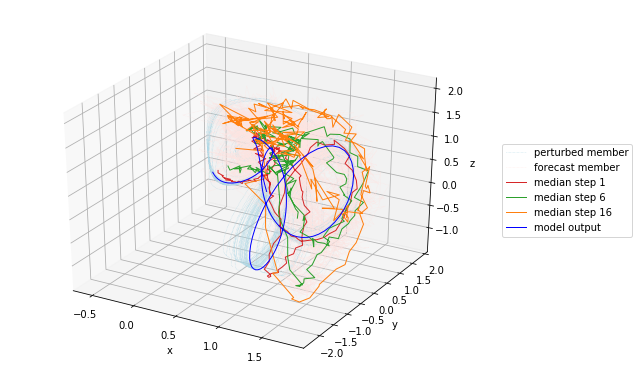

In [23]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e1500_p1000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e1500_p1000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e1500_p1000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e1500_p1000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e1500_p1000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e1500_p1000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e1500_p1000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e1500_p1000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e1500_p1000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e1500_p1000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e1500_p1000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e1500_p1000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e1500_p1000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e1500_p1000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e1500_p1000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0)   
#     ax.plot(data_ens[25, 0, :], data_ens[25, 1, :], data_ens[25, 2, :],
#             color='blue', label='model output', lw=1.0)    
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e1500_p1000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e1500_p1000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


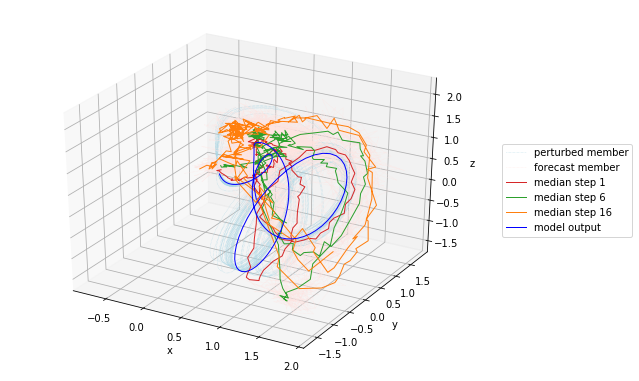

In [17]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p1000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p1000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p1000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p1000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p1000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p1000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p1000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p1000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p1000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p1000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p1000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p1000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p1000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p1000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p1000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0) 
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p1000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p1000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


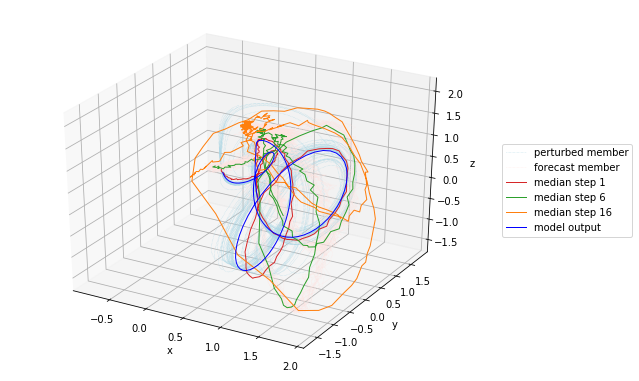

In [13]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p10000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p10000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p10000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p10000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p10000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p10000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p10000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p10000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p10000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p10000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p10000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p10000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p10000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p10000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p10000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0) 
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p10000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p10000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


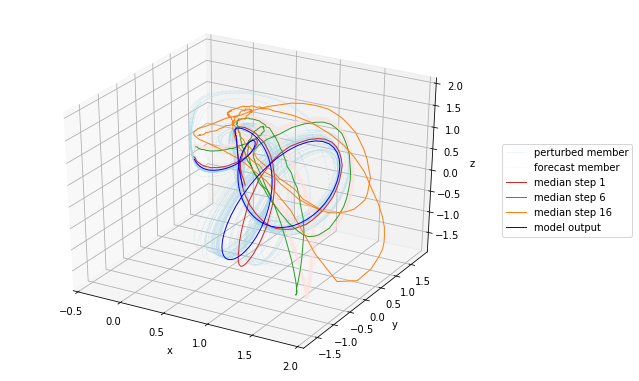

In [13]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p100000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p100000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p100000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p100000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p100000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p100000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p100000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p100000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p100000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0) 
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p100000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p100000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


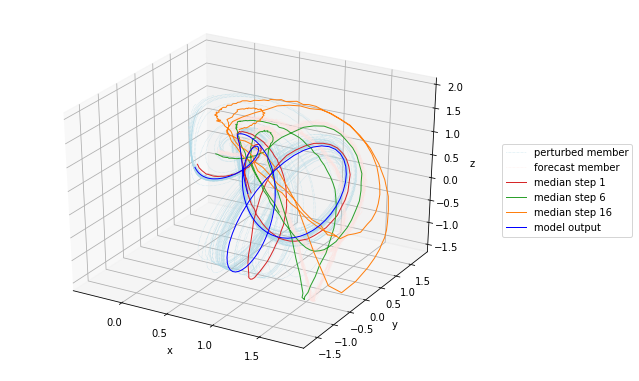

In [19]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p100000_stdx16[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p100000_stdx16[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p100000_stdx16[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p100000_stdx16[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p100000_stdx16[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p100000_stdx16[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p100000_stdx16[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100000_stdx16[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100000_stdx16[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p100000_stdx16[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100000_stdx16[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100000_stdx16[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p100000_stdx16[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p100000_stdx16[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p100000_stdx16[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0) 
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p100000_stdx16.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p100000_stdx16.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


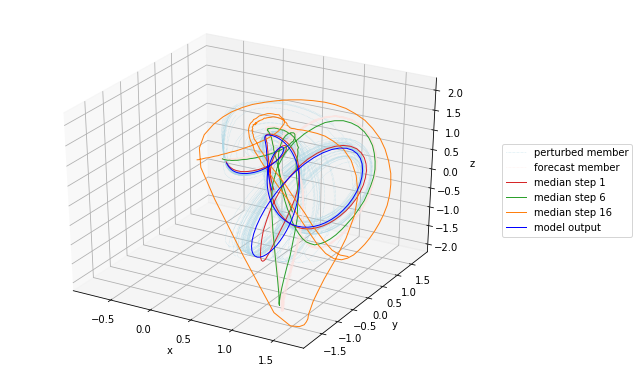

In [20]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p1000000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p1000000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p1000000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p1000000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p1000000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p1000000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p1000000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p1000000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p1000000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p1000000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p1000000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p1000000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p1000000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p1000000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p1000000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0) 
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p1000000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p1000000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================    trajectory - truncated  =====================


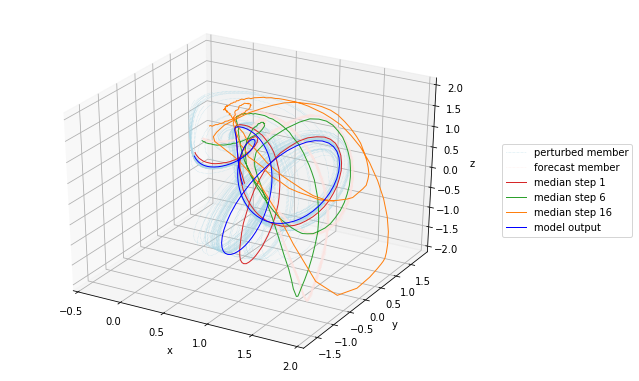

In [21]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    fig09 = plt.figure(figsize=(9,5.4))
    ax = fig09.gca(projection='3d')

    # Lorenz 84 model perturbed time series
    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='perturbed member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    # forecast members
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_e3000_p10000000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p10000000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p10000000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', label='forecast member', lw=0.5)
        else:
            ax.plot(predictand_e3000_p10000000_stdx4[i, 0, :, step_lead_display] * (x_max - x_min) + x_min,
                    predictand_e3000_p10000000_stdx4[i, 1, :, step_lead_display] * (y_max - y_min) + y_min,
                    predictand_e3000_p10000000_stdx4[i, 2, :, step_lead_display] * (z_max - z_min) + z_min,
                    color='mistyrose', linestyle='dotted', lw=0.5)            
    
    # median
    # step 1    
    ax.plot(predictand_median_e3000_p10000000_stdx4[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median_e3000_p10000000_stdx4[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median_e3000_p10000000_stdx4[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_median_e3000_p10000000_stdx4[0, :, 5] * (x_max - x_min) + x_min,
            predictand_median_e3000_p10000000_stdx4[1, :, 5] * (y_max - y_min) + y_min,
            predictand_median_e3000_p10000000_stdx4[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)
    
    # step 16    
    ax.plot(predictand_median_e3000_p10000000_stdx4[0, :, 15] * (x_max - x_min) + x_min,
            predictand_median_e3000_p10000000_stdx4[1, :, 15] * (y_max - y_min) + y_min,
            predictand_median_e3000_p10000000_stdx4[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0) 
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'perturbation_initialC_forecast_trajectory_e3000_p10000000_stdx4.png'),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'perturbation_modelP_forecast_trajectory_e3000_p10000000_stdx4.png'),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

In [22]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [23]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # lead time dependent CRPS
    crps_e3000_p100_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_e1500_p1000_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_e3000_p1000_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_e3000_p10000_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_e3000_p100000_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_e3000_p100000_stdx16 = np.zeros((step_lead,3), dtype=float)
    crps_e3000_p1000000_stdx4 = np.zeros((step_lead,3), dtype=float)
    crps_e3000_p10000000_stdx4 = np.zeros((step_lead,3), dtype=float)
    
    for i in range(step_lead):
        _, crps_e3000_p100_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p100_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p100_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100_stdx4[:,2,:,i]* (z_max - z_min) + z_min)

        _, crps_e1500_p1000_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e1500_p1000_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e1500_p1000_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e1500_p1000_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e1500_p1000_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e1500_p1000_stdx4[:,2,:,i]* (z_max - z_min) + z_min)
        
        _, crps_e3000_p1000_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p1000_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p1000_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p1000_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p1000_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p1000_stdx4[:,2,:,i]* (z_max - z_min) + z_min)
        
        _, crps_e3000_p10000_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p10000_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p10000_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p10000_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p10000_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p10000_stdx4[:,2,:,i]* (z_max - z_min) + z_min)
        
        _, crps_e3000_p100000_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100000_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p100000_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100000_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p100000_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100000_stdx4[:,2,:,i]* (z_max - z_min) + z_min)
        
        _, crps_e3000_p100000_stdx16[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100000_stdx16[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p100000_stdx16[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100000_stdx16[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p100000_stdx16[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p100000_stdx16[:,2,:,i]* (z_max - z_min) + z_min)
        
        _, crps_e3000_p1000000_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p1000000_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p1000000_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p1000000_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p1000000_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p1000000_stdx4[:,2,:,i]* (z_max - z_min) + z_min)
        
        _, crps_e3000_p10000000_stdx4[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p10000000_stdx4[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_e3000_p10000000_stdx4[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p10000000_stdx4[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_e3000_p10000000_stdx4[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_e3000_p10000000_stdx4[:,2,:,i]* (z_max - z_min) + z_min)

<Figure size 432x288 with 0 Axes>

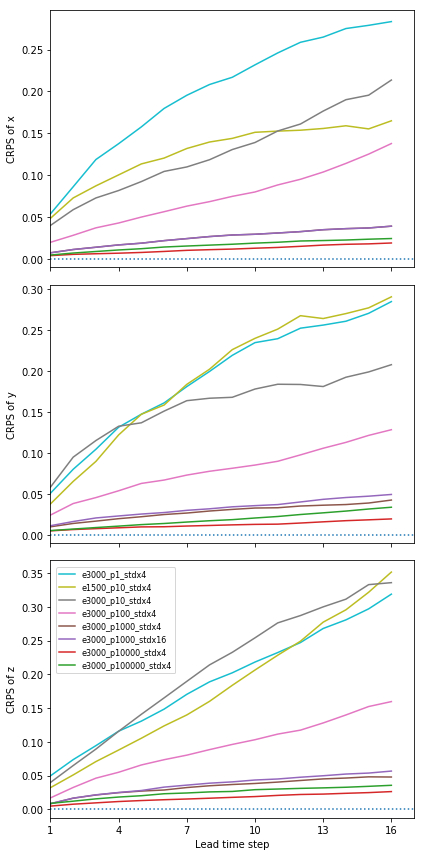

In [27]:
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    
    fig09 = plt.figure()
    fig09, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig09.set_size_inches(6, 12, forward=True)
    
    display_upto = 16
    
    # forecast 
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p100_stdx4[:display_upto,0], color=colormap[9], label='e3000_p1_stdx4')# taken as standard
    ax1.plot(np.arange(1, display_upto+1), crps_e1500_p1000_stdx4[:display_upto,0], color=colormap[8], label='e1500_p10_stdx4')
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p1000_stdx4[:display_upto,0], color=colormap[7], label='e3000_p10_stdx4')
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p10000_stdx4[:display_upto,0], color=colormap[6], label='e3000_p100_stdx4')
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p100000_stdx4[:display_upto,0], color=colormap[5], label='e3000_p1000_stdx4')
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p100000_stdx4[:display_upto,0], color=colormap[4], label='e3000_p1000_stdx16')
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p1000000_stdx4[:display_upto,0], color=colormap[3], label='e3000_p10000_stdx4')
    ax1.plot(np.arange(1, display_upto+1), crps_e3000_p10000000_stdx4[:display_upto,0], color=colormap[2], label='e3000_p100000_stdx4')
    
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p100_stdx4[:display_upto,1], color=colormap[9], label='e3000_p1_stdx4')
    ax2.plot(np.arange(1, display_upto+1), crps_e1500_p1000_stdx4[:display_upto,1], color=colormap[8], label='e1500_p10_stdx4')
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p1000_stdx4[:display_upto,1], color=colormap[7], label='e3000_p10_stdx4')
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p10000_stdx4[:display_upto,1], color=colormap[6], label='e3000_p100_stdx4')
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p100000_stdx4[:display_upto,1], color=colormap[5], label='e3000_p1000_stdx4')
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p100000_stdx16[:display_upto,1], color=colormap[4], label='e3000_p1000_stdx16')
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p1000000_stdx4[:display_upto,1], color=colormap[3], label='e3000_p10000_stdx4')
    ax2.plot(np.arange(1, display_upto+1), crps_e3000_p10000000_stdx4[:display_upto,1], color=colormap[2], label='e3000_p100000_stdx4')
    
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p100_stdx4[:display_upto,2], color=colormap[9], label='e3000_p1_stdx4')
    ax3.plot(np.arange(1, display_upto+1), crps_e1500_p1000_stdx4[:display_upto,2], color=colormap[8], label='e1500_p10_stdx4')
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p1000_stdx4[:display_upto,2], color=colormap[7], label='e3000_p10_stdx4')
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p10000_stdx4[:display_upto,2], color=colormap[6], label='e3000_p100_stdx4')
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p100000_stdx4[:display_upto,2], color=colormap[5], label='e3000_p1000_stdx4')
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p100000_stdx16[:display_upto,2], color=colormap[4], label='e3000_p1000_stdx16')
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p1000000_stdx4[:display_upto,2], color=colormap[3], label='e3000_p10000_stdx4')
    ax3.plot(np.arange(1, display_upto+1), crps_e3000_p10000000_stdx4[:display_upto,2], color=colormap[2], label='e3000_p100000_stdx4')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(1, display_upto+1)
    ax2.set_xlim(1, display_upto+1)
    ax3.set_xlim(1, display_upto+1)
    
    ax1.set_xticks(np.arange(1,display_upto+1,3))
    ax2.set_xticks(np.arange(1,display_upto+1,3))
    ax3.set_xticks(np.arange(1,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x")
    ax2.set_ylabel("CRPS of y")
    ax3.set_ylabel("CRPS of z")
    
    plt.xlabel("Lead time step")
    
    #ax1.legend(frameon=True, bbox_to_anchor=(0.99,0.03), prop={'size': 10.0}, loc=4)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    ax3.legend(frameon=True, bbox_to_anchor=(0.005,0.99), prop={'size': 8.0}, loc=2)
    
    plt.tight_layout()

    plt.show()
    fig09.savefig(os.path.join(output_path,'crps_hyperParameter.png'),dpi=150)

In [ ]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # RMSE
    def RMSE(obs, pred):
        """
        Root Mean Square Error.
        """
        rmse = np.sqrt(np.mean((obs - pred)**2))
        
        return rmse
    
    # lead time dependent RMSE of Bayesian LSTM forecast
    rmse_e3000_p100_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e1500_p1000_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e3000_p1000_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e3000_p10000_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e3000_p100000_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e3000_p100000_stdx16 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e3000_p1000000_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_e3000_p10000000_stdx4 = np.zeros((ens, step_lead, 3), dtype=float)
    #rmse_maxLike = np.zeros((step_lead, 3), dtype=float)
    
    for i in range(step_lead):
#         rmse_x_maxLike = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_maxLike[0,:,i]* (x_max - x_min) + x_min)
#         rmse_y_maxLike = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_maxLike[1,:,i]* (y_max - y_min) + y_min)
#         rmse_z_maxLike = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_maxLike[2,:,i]* (z_max - z_min) + z_min)
        
#         rmse_maxLike[i,0] = rmse_x_maxLike
#         rmse_maxLike[i,1] = rmse_y_maxLike
#         rmse_maxLike[i,2] = rmse_z_maxLike
        for n in range(ens):
            rmse_x_onetime = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_onetime[n,0,:,i]* (x_max - x_min) + x_min)
            rmse_y_onetime = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_onetime[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z_onetime = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_onetime[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_x_rapid = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_rapid[n,0,:,i]* (x_max - x_min) + x_min)
            rmse_y_rapid = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_rapid[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z_rapid = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_rapid[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_x_subsample = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_subsample[n,0,:,i]* (x_max - x_min) + x_min)
            rmse_y_subsample = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_subsample[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z_subsample = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_subsample[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_onetime[n,i,0] = rmse_x_onetime
            rmse_onetime[n,i,1] = rmse_y_onetime
            rmse_onetime[n,i,2] = rmse_z_onetime
            
            rmse_rapid[n,i,0] = rmse_x_rapid
            rmse_rapid[n,i,1] = rmse_y_rapid
            rmse_rapid[n,i,2] = rmse_z_rapid
            
            rmse_subsample[n,i,0] = rmse_x_subsample
            rmse_subsample[n,i,1] = rmse_y_subsample
            rmse_subsample[n,i,2] = rmse_z_subsample
            
    rmse_onetime_mean = np.mean(rmse_onetime, 0)
    rmse_rapid_mean = np.mean(rmse_rapid, 0)
    rmse_subsample_mean = np.mean(rmse_subsample, 0)
            
    # lead time dependent RMSE of persistence
    rmse_persist = np.zeros((step_lead,3), dtype=float)
    for i in range(step_lead):
        rmse_persist[i,0] = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], xx[-(test_len + step_lead)-1:-step_lead-1])
        rmse_persist[i,1] = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], yy[-(test_len + step_lead)-1:-step_lead-1])
        rmse_persist[i,2] = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], zz[-(test_len + step_lead)-1:-step_lead-1])

In [ ]:
    colormap=cm.tab20c(range(ens))
    
    # zoom in
    fig09 = plt.figure()
    fig09, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig09.set_size_inches(6, 12, forward=True)
    
    display_upto = 24
    
    # rmse of forecast
    ax1.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,0], 'b', label='one-time sampling')
    ax1.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,0], 'r', label='rapid sampling')
    ax1.plot(np.arange(1, display_upto+1), rmse_subsample_mean[:display_upto,0], 'k', label='sub sampling')
    ax1.plot(np.arange(1, display_upto+1), rmse_maxLike[:display_upto,0], 'g', label='maximum likelihood')
    ax1.plot(np.arange(1, display_upto+1), rmse_persist[:display_upto,0], 'c', label='persistence')
    
    ax2.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,1], 'b', label='one-time sampling')
    ax2.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,1], 'r', label='rapid sampling')
    ax2.plot(np.arange(1, display_upto+1), rmse_subsample_mean[:display_upto,1], 'k', label='sub sampling')
    ax2.plot(np.arange(1, display_upto+1), rmse_maxLike[:display_upto,1], 'g', label='maximum likelihood')
    ax2.plot(np.arange(1, display_upto+1), rmse_persist[:display_upto,1], 'c', label='persistence')
    
    ax3.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,2], 'b', label='one-time sampling')
    ax3.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,2], 'r', label='rapid sampling')
    ax3.plot(np.arange(1, display_upto+1), rmse_subsample_mean[:display_upto,2], 'k', label='sub sampling')
    ax3.plot(np.arange(1, display_upto+1), rmse_maxLike[:display_upto,2], 'g', label='maximum likelihood')
    ax3.plot(np.arange(1, display_upto+1), rmse_persist[:display_upto,2], 'c', label='persistence')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(1, display_upto + 1)
    ax2.set_xlim(1, display_upto + 1)
    ax3.set_xlim(1, display_upto + 1)
    
    ax1.set_xticks(np.arange(1,display_upto+1,3))
    ax2.set_xticks(np.arange(1,display_upto+1,3))
    ax3.set_xticks(np.arange(1,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x")
    ax2.set_ylabel("RMSE of y")
    ax3.set_ylabel("RMSE of z")
    
    plt.xlabel("Lead timestep")
    #ax1.legend(frameon=True, bbox_to_anchor=(0.99,0.01), prop={'size': 10.0}, loc=4)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.99,0.01), prop={'size': 10.0}, loc=4)
    ax3.legend(frameon=True, bbox_to_anchor=(0.99,0.01), prop={'size': 10.0}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig09.savefig(os.path.join(output_path,'rmse_onetime_rapid_subsampling_maxLike.png'),dpi=150)

In [ ]:
    # zoom in and all members
    fig10 = plt.figure()
    fig10, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig10.set_size_inches(6, 12, forward=True)
    
    display_upto = 16
    
    # each member rmse of forecast
    for i in range(ens):
        if i == 0:
            ax1.plot(np.arange(1, display_upto+1), rmse_onetime[i,:display_upto,0],
                     color='lightblue', linestyle='dotted', label='one-time sampling member')
            ax1.plot(np.arange(1, display_upto+1), rmse_rapid[i,:display_upto,0],
                     color='lightcoral', linestyle='dotted', label='rapid sampling member')
        else:
            ax1.plot(np.arange(1, display_upto+1), rmse_onetime[i,:display_upto,0],
                     color='lightblue', linestyle='dotted')
            ax1.plot(np.arange(1, display_upto+1), rmse_rapid[i,:display_upto,0],
                     color='lightcoral', linestyle='dotted')            
    
    # mean rmse of forecast
    ax1.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,0], 'b', label='one-time sampling')
    ax1.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,0], 'r', label='rapid sampling')
    ax1.plot(np.arange(1, display_upto+1), rmse_maxLike[:display_upto,0], 'g', label='Maximum Likelihood')
    
    # each member rmse of forecast
    for i in range(ens):
        if i == 0:
            ax2.plot(np.arange(1, display_upto+1), rmse_onetime[i,:display_upto,1],
                     color='lightblue', linestyle='dotted', label='one-time sampling member')
            ax2.plot(np.arange(1, display_upto+1), rmse_rapid[i,:display_upto,1],
                     color='lightcoral', linestyle='dotted', label='rapid sampling member')
        else:
            ax2.plot(np.arange(1, display_upto+1), rmse_onetime[i,:display_upto,1],
                     color='lightblue', linestyle='dotted')
            ax2.plot(np.arange(1, display_upto+1), rmse_rapid[i,:display_upto,1],
                     color='lightcoral', linestyle='dotted')     
    
    ax2.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,1], 'b', label='one-time sampling')
    ax2.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,1], 'r', label='rapid sampling')
    #ax2.plot(np.arange(1, display_upto+1), rmse_maxLike[:display_upto,1], 'g', label='Maximum Likelihood')

    # each member rmse of forecast
    for i in range(ens):
        if i == 0:
            ax3.plot(np.arange(1, display_upto+1), rmse_onetime[i,:display_upto,2],
                     color='lightblue', linestyle='dotted', label='one-time sampling member')
            ax3.plot(np.arange(1, display_upto+1), rmse_rapid[i,:display_upto,2],
                     color='lightcoral', linestyle='dotted', label='rapid sampling member')
        else:
            ax3.plot(np.arange(1, display_upto+1), rmse_onetime[i,:display_upto,2],
                     color='lightblue', linestyle='dotted')
            ax3.plot(np.arange(1, display_upto+1), rmse_rapid[i,:display_upto,2],
                     color='lightcoral', linestyle='dotted')
    
    ax3.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,2], 'b', label='one-time sampling')
    ax3.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,2], 'r', label='rapid sampling')
    ax3.plot(np.arange(1, display_upto+1), rmse_maxLike[:display_upto,2], 'g', label='Maximum Likelihood')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(1, display_upto)
    ax2.set_xlim(1, display_upto)
    ax3.set_xlim(1, display_upto)
    
    ax1.set_xticks(np.arange(1,display_upto+1,3))
    ax2.set_xticks(np.arange(1,display_upto+1,3))
    ax3.set_xticks(np.arange(1,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x")
    ax2.set_ylabel("RMSE of y")
    ax3.set_ylabel("RMSE of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.01,0.995), prop={'size': 10.0}, loc=2)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig10.savefig(os.path.join(output_path,'rmse_onetime_rapid_member.png'),dpi=150)

In [37]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    euclidean_e3000_p100_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float) # the starting point is 0
    euclidean_e1500_p1000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_e3000_p1000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_e3000_p10000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_e3000_p100000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_e3000_p100000_stdx16_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_e3000_p1000000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_e3000_p10000000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    #euclidean_maxLike = np.zeros(step_lead, dtype=float)
    euclidean_persist = np.zeros(step_lead+1, dtype=float)
    
    # median of the largest ensemble
    #euclidean_median_e3000_p10000_stdx4 = np.zeros(step_lead, dtype=float)
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    predictand_e3000_p100_stdx4_denorm = np.zeros(predictand_e3000_p100_stdx4.shape, dtype=float)
    predictand_e3000_p100_stdx4_denorm[:,0,:,:] = predictand_e3000_p100_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p100_stdx4_denorm[:,1,:,:] = predictand_e3000_p100_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p100_stdx4_denorm[:,2,:,:] = predictand_e3000_p100_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e1500_p1000_stdx4_denorm = np.zeros(predictand_e1500_p1000_stdx4.shape, dtype=float)
    predictand_e1500_p1000_stdx4_denorm[:,0,:,:] = predictand_e1500_p1000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e1500_p1000_stdx4_denorm[:,1,:,:] = predictand_e1500_p1000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e1500_p1000_stdx4_denorm[:,2,:,:] = predictand_e1500_p1000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e3000_p1000_stdx4_denorm = np.zeros(predictand_e3000_p1000_stdx4.shape, dtype=float)
    predictand_e3000_p1000_stdx4_denorm[:,0,:,:] = predictand_e3000_p1000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p1000_stdx4_denorm[:,1,:,:] = predictand_e3000_p1000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p1000_stdx4_denorm[:,2,:,:] = predictand_e3000_p1000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e3000_p10000_stdx4_denorm = np.zeros(predictand_e3000_p10000_stdx4.shape, dtype=float)
    predictand_e3000_p10000_stdx4_denorm[:,0,:,:] = predictand_e3000_p10000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p10000_stdx4_denorm[:,1,:,:] = predictand_e3000_p10000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p10000_stdx4_denorm[:,2,:,:] = predictand_e3000_p10000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e3000_p100000_stdx4_denorm = np.zeros(predictand_e3000_p100000_stdx4.shape, dtype=float)
    predictand_e3000_p100000_stdx4_denorm[:,0,:,:] = predictand_e3000_p100000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p100000_stdx4_denorm[:,1,:,:] = predictand_e3000_p100000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p100000_stdx4_denorm[:,2,:,:] = predictand_e3000_p100000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e3000_p100000_stdx16_denorm = np.zeros(predictand_e3000_p100000_stdx16.shape, dtype=float)
    predictand_e3000_p100000_stdx16_denorm[:,0,:,:] = predictand_e3000_p100000_stdx16[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p100000_stdx16_denorm[:,1,:,:] = predictand_e3000_p100000_stdx16[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p100000_stdx16_denorm[:,2,:,:] = predictand_e3000_p100000_stdx16[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e3000_p1000000_stdx4_denorm = np.zeros(predictand_e3000_p1000000_stdx4.shape, dtype=float)
    predictand_e3000_p1000000_stdx4_denorm[:,0,:,:] = predictand_e3000_p1000000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p1000000_stdx4_denorm[:,1,:,:] = predictand_e3000_p1000000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p1000000_stdx4_denorm[:,2,:,:] = predictand_e3000_p1000000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_e3000_p10000000_stdx4_denorm = np.zeros(predictand_e3000_p10000000_stdx4.shape, dtype=float)
    predictand_e3000_p10000000_stdx4_denorm[:,0,:,:] = predictand_e3000_p10000000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    predictand_e3000_p10000000_stdx4_denorm[:,1,:,:] = predictand_e3000_p10000000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    predictand_e3000_p10000000_stdx4_denorm[:,2,:,:] = predictand_e3000_p10000000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
#     predictand_maxLike_denorm = np.zeros(predictand_maxLike.shape, dtype=float)
#     predictand_maxLike_denorm[0,:,:] = predictand_maxLike[0,:,:] * (x_max - x_min) + x_min
#     predictand_maxLike_denorm[1,:,:] = predictand_maxLike[1,:,:] * (y_max - y_min) + y_min
#     predictand_maxLike_denorm[2,:,:] = predictand_maxLike[2,:,:] * (z_max - z_min) + z_min 
    
#     predictand_median_e3000_p10000_stdx4_denorm = np.zeros(predictand_median_e3000_p10000_stdx4.shape, dtype=float)
#     predictand_median_e3000_p10000_stdx4_denorm[0,:,:] = predictand_median_e3000_p10000_stdx4[0,:,:] * (x_max - x_min) + x_min
#     predictand_median_e3000_p10000_stdx4_denorm[1,:,:] = predictand_median_e3000_p10000_stdx4[1,:,:] * (y_max - y_min) + y_min
#     predictand_median_e3000_p10000_stdx4_denorm[2,:,:] = predictand_median_e3000_p10000_stdx4[2,:,:] * (z_max - z_min) + z_min    
    
    for i in range(step_lead):
#         euclidean_maxLike[i] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_maxLike_denorm[:,:,i])
        euclidean_persist[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], obs[:,-(test_len + step_lead)-1:-step_lead-1])
#         euclidean_median_e3000_p10000_stdx4[i] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
#                                                            predictand_median_e3000_p10000_stdx4_denorm[:,:,i])
        for n in range(ens):
            euclidean_e3000_p100_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                     predictand_e3000_p100_stdx4_denorm[n,:,:,i])
            euclidean_e1500_p1000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e1500_p1000_stdx4_denorm[n,:,:,i])
            euclidean_e3000_p1000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e3000_p1000_stdx4_denorm[n,:,:,i])
            euclidean_e3000_p10000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e3000_p10000_stdx4_denorm[n,:,:,i])
            euclidean_e3000_p100000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e3000_p100000_stdx4_denorm[n,:,:,i])
            euclidean_e3000_p100000_stdx16_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e3000_p100000_stdx16_denorm[n,:,:,i])
            euclidean_e3000_p1000000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e3000_p1000000_stdx4_denorm[n,:,:,i])
            euclidean_e3000_p10000000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
                                                      predictand_e3000_p10000000_stdx4_denorm[n,:,:,i])
            
            euclidean_e3000_p100_stdx4_ens[n,i+1] = euclidean_e3000_p100_stdx4_n
            euclidean_e1500_p1000_stdx4_ens[n,i+1] = euclidean_e1500_p1000_stdx4_n
            euclidean_e3000_p1000_stdx4_ens[n,i+1] = euclidean_e3000_p1000_stdx4_n
            euclidean_e3000_p10000_stdx4_ens[n,i+1] = euclidean_e3000_p10000_stdx4_n
            euclidean_e3000_p100000_stdx4_ens[n,i+1] = euclidean_e3000_p100000_stdx4_n
            euclidean_e3000_p100000_stdx16_ens[n,i+1] = euclidean_e3000_p100000_stdx16_n
            euclidean_e3000_p1000000_stdx4_ens[n,i+1] = euclidean_e3000_p1000000_stdx4_n
            euclidean_e3000_p10000000_stdx4_ens[n,i+1] = euclidean_e3000_p10000000_stdx4_n
            
    euclidean_e3000_p100_stdx4 = np.mean(euclidean_e3000_p100_stdx4_ens, 0)
    euclidean_e1500_p1000_stdx4 = np.mean(euclidean_e1500_p1000_stdx4_ens, 0)
    euclidean_e3000_p1000_stdx4 = np.mean(euclidean_e3000_p1000_stdx4_ens, 0)
    euclidean_e3000_p10000_stdx4 = np.mean(euclidean_e3000_p10000_stdx4_ens, 0)
    euclidean_e3000_p100000_stdx4 = np.mean(euclidean_e3000_p100000_stdx4_ens, 0)
    euclidean_e3000_p100000_stdx16 = np.mean(euclidean_e3000_p100000_stdx16_ens, 0)
    euclidean_e3000_p1000000_stdx4 = np.mean(euclidean_e3000_p1000000_stdx4_ens, 0)
    euclidean_e3000_p10000000_stdx4 = np.mean(euclidean_e3000_p10000000_stdx4_ens, 0)

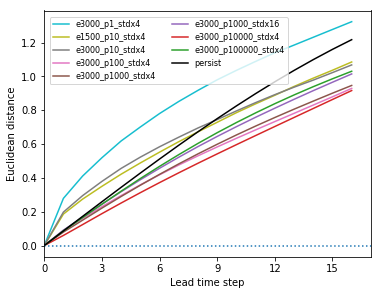

In [40]:
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    # zoom in
    display_upto = 16
    
    fig12 = plt.figure()
    fig12.set_size_inches(5.4, 4.2, forward=True)
    
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p100_stdx4[:display_upto+1], color=colormap[9], label='e3000_p1_stdx4')
    plt.plot(np.arange(display_upto+1), euclidean_e1500_p1000_stdx4[:display_upto+1], color=colormap[8], label='e1500_p10_stdx4')
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p1000_stdx4[:display_upto+1], color=colormap[7], label='e3000_p10_stdx4')
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p10000_stdx4[:display_upto+1], color=colormap[6], label='e3000_p100_stdx4')
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p100000_stdx4[:display_upto+1], color=colormap[5], label='e3000_p1000_stdx4')
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p100000_stdx16[:display_upto+1], color=colormap[4], label='e3000_p1000_stdx16')
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p1000000_stdx4[:display_upto+1], color=colormap[3], label='e3000_p10000_stdx4')
    plt.plot(np.arange(display_upto+1), euclidean_e3000_p10000000_stdx4[:display_upto+1], color=colormap[2], label='e3000_p100000_stdx4')
#     plt.plot(np.arange(1, display_upto+1), euclidean_maxLike[:display_upto], 'g', label='maximum likelihood')
    plt.plot(np.arange(display_upto+1), euclidean_persist[:display_upto+1], 'k', label='persist')
    #plt.plot(np.arange(1, display_upto+1), euclidean_median_e3000_p10000_stdx4[:display_upto], 'm', label='e3000_p10000_stdx4 median')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto+1)
    plt.xticks(np.arange(0,display_upto+1,3))
    
    #plt.ylim(0, 2.5)
    #plt.yticks(np.arange(0,2.5,0.2))
    plt.ylabel("Euclidean distance")
    plt.xlabel("Lead time step")
    
    plt.legend(frameon=True, prop={'size': 8.0}, bbox_to_anchor=(0.005,0.99), loc=2, ncol=2)
    #plt.legend(frameon=True, prop={'size': 8.0}, bbox_to_anchor=(0.99,0.005), loc=4, ncol=2)
    plt.tight_layout()

    plt.show()
    fig12.savefig(os.path.join(output_path,'euclidean_Hyperparameter.png'),dpi=150)